In [5]:
import pandas as pd
from collections import OrderedDict
import pytz

full_file_path = "SPY.csv"
data = OrderedDict()
data['SPY'] = pd.read_csv(full_file_path, index_col=0, parse_dates=['date'])
data['SPY'] = data['SPY'][["open","high","low","close","volume"]]
data['SPY'] = data['SPY'].resample("1d").mean()
data['SPY'].fillna(method="ffill", inplace=True)
print(data['SPY'].head())

               open     high      low    close     volume
date                                                     
1993-01-29  43.9687  43.9687  43.7500  43.9375  1003200.0
1993-01-30  43.9687  43.9687  43.7500  43.9375  1003200.0
1993-01-31  43.9687  43.9687  43.7500  43.9375  1003200.0
1993-02-01  43.9687  44.2500  43.9687  44.2500   480500.0
1993-02-02  44.2187  44.3750  44.1250  44.3437   201300.0


Whenever you have all of your dataframes stored in this dictionary, you can then convert it to a panel, like so:

In [6]:
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 9178 (major_axis) x 5 (minor_axis)
Items axis: SPY to SPY
Major_axis axis: 1993-01-29 00:00:00+00:00 to 2018-03-16 00:00:00+00:00
Minor_axis axis: open to volume


With this panel now, we can actually pass this as our "data" to our backtest, like this:

In [7]:
from zipline.api import order, record, symbol, set_benchmark
import zipline
import matplotlib.pyplot as plt
from datetime import datetime


def initialize(context):
    set_benchmark(symbol("SPY"))


def handle_data(context, data):
    order(symbol("SPY"), 10)
    record(SPY=data.current(symbol('SPY'), 'price'))

perf = zipline.run_algorithm(start=datetime(2017, 1, 5, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2018, 3, 1, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      data=panel)

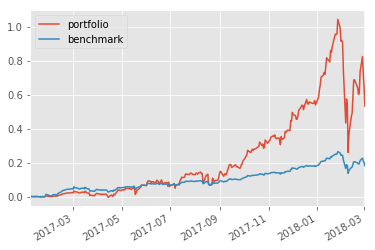

In [8]:
import matplotlib.pyplot as plt
from matplotlib import style


style.use("ggplot")

perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.SPY.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.legend(loc=2)

plt.show()

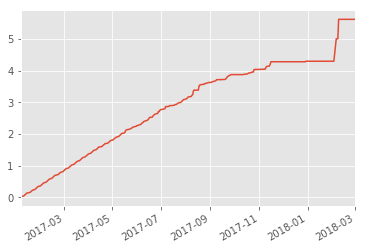

In [9]:
perf.max_leverage.plot()
plt.show()